# Final Project
Jack Dean  
Math 469 - Financial Stochastic Analysis  
Lehigh University

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
t_bonds_df = pd.read_excel('Table.xlsx')
t_bonds_df['px_last'] = [i if i>=25 else 100 - i for i in t_bonds_df['ask'].to_list()]
t_bonds_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in t_bonds_df['maturity']]
t_bonds_df['bond'] = ['T '+ str(t_bonds_df.iloc[i,1]) + ' '+ t_bonds_df.iloc[i,0].strftime('%m/%d/%y') for i in t_bonds_df.index]
t_bonds_df = t_bonds_df.set_index('bond')

In [3]:
t_bonds_df

,maturity,coupon,bid,ask,ask_yield,px_last,ttm
bond,,,,,,,
T 0.0 05/10/22,2022-05-10,0.000,0.120,0.110,0.112,99.890,0.003775
T 0.0 05/12/22,2022-05-12,0.000,0.195,0.185,0.188,99.815,0.009254
T 0.0 05/17/22,2022-05-17,0.000,0.260,0.250,0.254,99.750,0.022953
T 0.0 05/19/22,2022-05-19,0.000,0.265,0.255,0.259,99.745,0.028432
T 0.0 05/24/22,2022-05-24,0.000,0.388,0.378,0.383,99.622,0.042131
...,...,...,...,...,...,...,...
T 1.875 02/15/51,2051-02-15,1.875,77.250,77.270,3.035,77.270,28.792816
T 2.375 05/15/51,2051-05-15,2.375,87.106,87.126,3.031,87.126,29.036651
T 2.0 08/15/51,2051-08-15,2.000,80.066,80.086,3.020,80.086,29.288706


In [4]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in t_bonds_df[t_bonds_df['ttm'] <= 0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    cpn = bond['coupon']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in t_bonds_df[t_bonds_df['ttm']>=0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['coupon']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

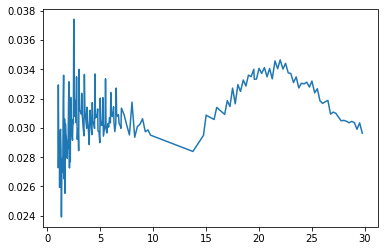

In [5]:
plt.plot(rates[1:])

In [6]:
M = 10000
n = 30 * 100
w_t = []
for i in range(M):
    w_t.append(np.cumsum(np.random.randn(n)*np.sqrt(0.01)))
t_i = np.array([i/100 for i in range(n)])

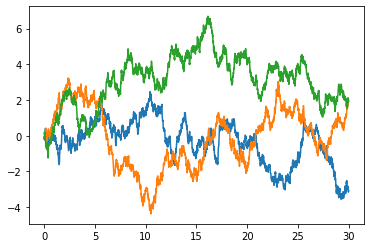

In [7]:
plt.plot(t_i,w_t[0])
plt.plot(t_i,w_t[1])
plt.plot(t_i,w_t[3])

In [8]:
r_0 = 0.01 # fed funds target
move = 121.99 / 100 # MOVE index

In [9]:
'''
14 minutes
'''
Theta = []
for i in range(M):
        Theta.append([(rates.loc[t] - r_0 + move*w_t[i][int(t*100)])[0] for t in rates.index])

In [10]:
theta_est = pd.DataFrame(data=Theta,columns=rates.index).mean()

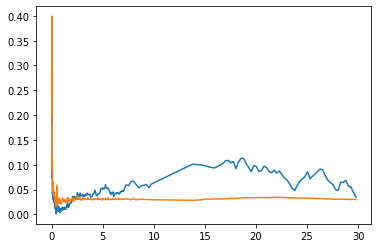

In [11]:
plt.plot(theta_est)
plt.plot(rates)

In [12]:
yc_2s10s = theta_est[:10].iloc[-1] - theta_est[:2].iloc[-1]
yc_10s_30s = theta_est[:30].iloc[-1] - theta_est[:10].iloc[-1]

In [13]:
print('2s10s implied yield curve: {:.2f}bps'.format(yc_2s10s*100))
print('10s30s implied yield curve: {:.2f}bps'.format(yc_10s_30s*100))

2s10s implied yield curve: 3.14bps
10s30s implied yield curve: -2.68bps


In [14]:
slices = [(theta_est.index[i+1] - theta_est.index[i])*theta_est[theta_est.index[i+1]] for i in range(len(theta_est.index[:-1]))]
theta_int = pd.DataFrame(theta_est.iloc[1:], columns=['Theta'])
integral = [sum(slices[:i]) for i in range(len(slices))]
theta_int['int'] = integral

In [15]:
theta_int

,Theta,int
ttm,,
0.01,0.186102,0.000000
0.02,0.384478,0.001861
0.03,0.074541,0.005706
0.04,0.075214,0.006451
0.05,0.073315,0.007203
...,...,...
28.79,0.068606,2.084267
29.04,0.057048,2.101418
29.29,0.054933,2.115680


In [16]:
bond_pxs = [[np.exp(-(r_0 * i) - theta_int['int'][i] + (move**2)*(i**3)/6 - move*i*w_t[j][int(i*100)]) for i in theta_int.index] for j in range(M)]

C:\Users\jdean\AppData\Local\Temp/ipykernel_35820/4209142978.py:1: RuntimeWarning: overflow encountered in exp
  bond_pxs = [[np.exp(-(r_0 * i) - theta_int['int'][i] + (move**2)*(i**3)/6 - move*i*w_t[j][int(i*100)]) for i in theta_int.index] for j in range(M)]


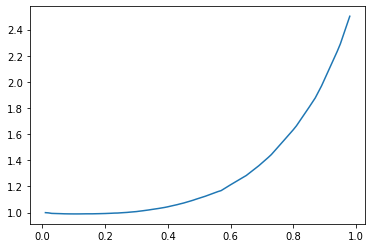

In [17]:
plt.plot(pd.DataFrame(bond_pxs,columns=theta_int.index).mean()[:1])

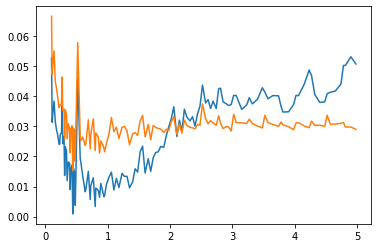

In [18]:
plt.plot(theta_est[0.1:5])
plt.plot(rates[0.1:5])